<h1>Ufc punch detection</h1>
<h3>This notebook trains a detectron model using a custom dataset to predict bounding boxes around fighters in an image and label the box as either "punch" or "not punch"</h3>

In [1]:
# ensure the GPU is available
!nvidia-smi

Wed Nov 15 02:36:31 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.09                 Driver Version: 532.09       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060       WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8                9W /  N/A|    799MiB /  6144MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# install detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
# import necessary libraries
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler drivertorch:  2.0 ; cuda:  cu118
detectron2: 0.6

Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

<h3>Test default model

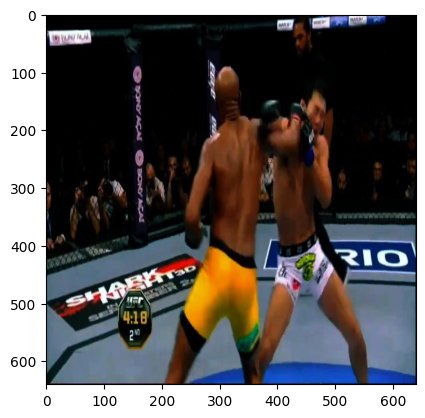

In [4]:
# read a random image
image = cv2.imread("train\\blocked_punch650_jpg.rf.12bbf6f7f43f9844a717c74a39a68e67.jpg")
import matplotlib.pyplot as plt
plt.imshow(image[:,:,::-1])

In [5]:
# download the model and checkpoints
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(image)

c:\Users\G5\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
# there are two forms of output - the boxes and their labels
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0,  0,  0,  0,  0, 67,  0,  0], device='cuda:0')
Boxes(tensor([[262.7078,  98.5697, 563.8463, 630.9416],
        [224.0777,  68.0175, 434.9220, 632.1219],
        [169.0959, 257.2904, 206.5373, 364.7151],
        [204.5173, 244.4588, 241.9611, 340.3397],
        [ 38.6239, 289.2841, 106.7510, 407.0566],
        [430.2694, 162.5181, 464.7665, 263.0562],
        [ 93.1674, 281.0038, 143.3731, 377.0421],
        [  0.7978, 281.4697,  49.3070, 415.7459]], device='cuda:0'))


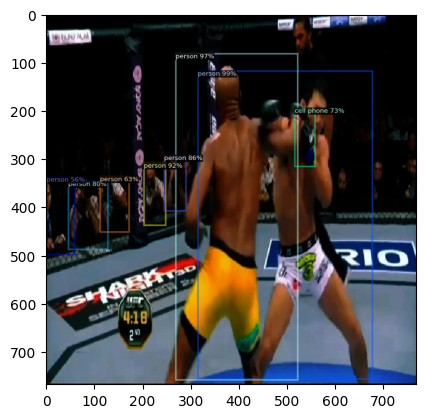

In [7]:
#visualize the default model's results
visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())

<h3> Register the custom dataset

The data consists of train,test and valid date labelled using labelimg.py tool with the labels reformatted to a coco file using roboflow.com

In [8]:
#Register all the datasets

ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
# TRAIN SET
TRAIN_DATA_SET_NAME = "data"
TRAIN_DATA_SET_IMAGES_DIR_PATH = "train"
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join( "train",ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME,
    metadata={},
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH,
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = "testdata"
TEST_DATA_SET_IMAGES_DIR_PATH = "test"
TEST_DATA_SET_ANN_FILE_PATH = os.path.join("test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME,
    metadata={},
    json_file=TEST_DATA_SET_ANN_FILE_PATH,
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = "validdata"
VALID_DATA_SET_IMAGES_DIR_PATH = "valid"
VALID_DATA_SET_ANN_FILE_PATH = os.path.join("valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME,
    metadata={},
    json_file=VALID_DATA_SET_ANN_FILE_PATH,
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

In [9]:
# ensure the entire dataset has been registered with coco. 
# we are searching the registered datasets for the names we registered for our test, train and validation dataset.
[
    data_set
    for data_set
    in MetadataCatalog.list()
    if "data" in data_set
]

['data', 'testdata', 'validdata']

<h3> Visualize


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



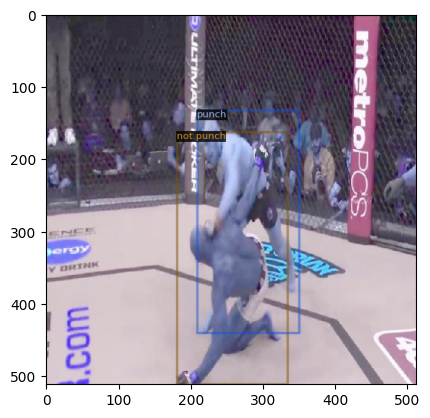

In [10]:
# visualize the bounding box and label of the training set created 

import matplotlib.pyplot as plt
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[0]
image = cv2.imread(dataset_entry["file_name"])

visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata,
    scale=0.8,
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
plt.imshow(out.get_image()[:, :, ::-1])

<h3> Train Model Using Custom COCO Format Dataset

In [11]:
# HYPERPARAMETERS
ARCHITECTURE = "faster_rcnn_R_50_FPN_3x"
CONFIG_FILE_PATH = f"COCO-Detection/{ARCHITECTURE}.yaml"
MAX_ITER = 2000
EVAL_PERIOD = 200
BASE_LR = 0.01
NUM_CLASSES = 3

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    ARCHITECTURE,
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

In [13]:
metadata

namespace(name='data',
          json_file='train\\_annotations.coco.json',
          image_root='train',
          evaluator_type='coco',
          thing_classes=['punches-and-kicks-in-mma-fights',
                         'not punch',
                         'punch'],
          thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2})

### Training

In [ ]:
#Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

<h3> Evaluation

In [14]:
# set the output dir to desired model, do not run this if you want the most recently trained model!
cfg.OUTPUT_DIR = "faster_rcnn_R_50_FPN_3x\\lr=0.001,itr=3000"

In [15]:
#configuring imported model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

In [16]:
# visualizing test dataset
dataset_valid = DatasetCatalog.get(TEST_DATA_SET_NAME)
result= []
for d in dataset_valid:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    result.append(out.get_image()[:, :, ::-1])


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



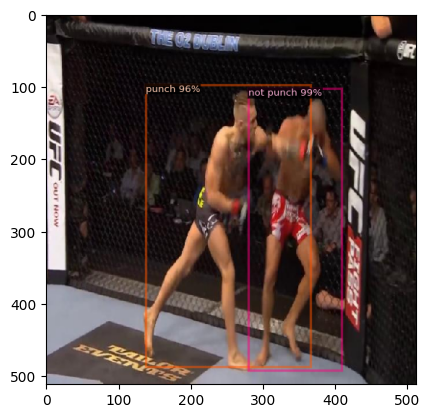

In [18]:
#picking a random image to see the results
plt.imshow(result[13][:,:,::-1])